In [16]:
import tables
import pandas as pd
import numpy as np
import cv2
from scipy import stats
import os
import re
from matplotlib import pyplot as plt

In [17]:
def clean_df(df):
    #remove redundant top level
    data = df['DLC_3D']
    #flatten data frame
    data.columns = [' '.join(col).strip() for col in data.columns.values]
    clean = data.copy()
    return data

In [18]:
traj_data = "./example_postprocessing/"
ground_dir = os.path.join(traj_data, 'ground')
print(ground_dir)
df = None
for file in os.listdir(ground_dir):
    if '_3D' in file and 'h5' in file:
        # found the ground 3D file.
        print(file)
        df = pd.read_hdf(os.path.join(traj_data, 'ground', file))
if df is None:
    raise RuntimeError

data = clean_df(df)
data.describe()

./example_postprocessing/ground
ground_DLC_3D.h5


bodypart1 x  bodypart1 y  bodypart1 z  bodypart2 x  bodypart2 y  \
count    15.000000    15.000000    15.000000    15.000000    15.000000   
mean    -61.040977    -6.018380    57.522296   -58.766216    -7.267664   
std       0.048596     0.011652     0.063348     0.123308     0.019773   
min     -61.127413    -6.043265    57.424785   -58.980578    -7.308217   
25%     -61.075223    -6.025409    57.466464   -58.850580    -7.284105   
50%     -61.031937    -6.017395    57.513532   -58.785137    -7.262627   
75%     -61.004081    -6.011319    57.572223   -58.712248    -7.252295   
max     -60.949511    -5.999713    57.623041   -58.548861    -7.243225   

       bodypart2 z  bodypart3 x  bodypart3 y  bodypart3 z  bodypart4 x  \
count    15.000000    15.000000    15.000000    15.000000          0.0   
mean     57.632265   -56.021703    -5.263688    60.063217          NaN   
std       0.152563     0.065796     0.022383     0.119012          NaN   
min      57.358246   -56.157202    -5.305079    59.963646          NaN   
25%      57.559004   -56.062936    -5.271954    59.973909          NaN   
50%      57.656773   -55.996551    -5.265970    60.005636          NaN   
75%      57.727425   -55.970889    -5.254664    60.139887          NaN   
max      57.891459   -55.949906    -5.213535    60.293067          NaN   

       bodypart4 y  bodypart4 z  bodypart5 x  bodypart5 y  bodypart5 z  \
count          0.0          0.0          0.0          0.0          0.0   
mean           NaN          NaN          NaN          NaN          NaN   
std            NaN          NaN          NaN          NaN          NaN   
min            NaN          NaN          NaN          NaN          NaN   
25%            NaN          NaN          NaN          NaN          NaN   
50%            NaN          NaN          NaN          NaN          NaN   
75%            NaN          NaN          NaN          NaN          NaN   
max            NaN          NaN          NaN          NaN          NaN   

       bodypart6 x  bodypart6 y  bodypart6 z  
count     9.000000     9.000000     9.000000  
mean    -56.542151     0.894602    65.373182  
std       0.083140     0.057146     0.103880  
min     -56.662136     0.822785    65.248118  
25%     -56.593942     0.855628    65.295922  
50%     -56.559061     0.862034    65.359157  
75%     -56.478179     0.937130    65.466986  
max     -56.425131     0.983587    65.546066

In [19]:
ref_coords = data.iloc[:, list(range(0, 9))]
ref_coords.dropna(inplace=True)
ref_coords.head()
    

<ipython-input-19-98a2120fa965>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref_coords.dropna(inplace=True)


bodypart1 x  bodypart1 y  bodypart1 z  bodypart2 x  bodypart2 y  \
0   -61.087300    -5.999713    57.576616   -58.726604    -7.247610   
1   -61.127413    -6.023282    57.623041   -58.713512    -7.243225   
2   -61.028891    -6.006521    57.513532   -58.641368    -7.247749   
3   -61.082785    -6.017395    57.596243   -58.713415    -7.257353   
4   -61.000955    -6.029686    57.471370   -58.785137    -7.270434   

   bodypart2 z  bodypart3 x  bodypart3 y  bodypart3 z  
0    57.593175   -56.157202    -5.257081    60.293067  
1    57.585725   -56.126618    -5.273027    60.289229  
2    57.493490   -56.059664    -5.270881    60.123598  
3    57.535163   -56.019363    -5.267799    60.014239  
4    57.656773   -55.962920    -5.276193    59.963811

g1 is the left of the hole, g2 is the top, g3 if right

In [20]:
g1_coords = data.iloc[:, list(range(0, 3))].to_numpy()
g2_coords = data.iloc[:, list(range(3, 6))].to_numpy()
g3_coords = data.iloc[:, list(range(6, 9))].to_numpy()

g1_vec = np.median(g1_coords, axis=0)
g2_vec = np.median(g2_coords, axis=0)
g3_vec = np.median(g3_coords, axis=0)

print(g1_vec)
print(g2_vec)
print(g3_vec)

[-61.03193717  -6.01739479  57.51353246]
[-58.78513747  -7.2626272   57.65677268]
[-55.99655081  -5.26596952  60.00563573]


i_m is paralel to the ground along the mask

k_m is orthoganal to the ground along the mask

j_m is orthoganal to the mask

In [21]:
i_m = (g1_vec - g3_vec)
# i_m = i_mr / np.linalg.norm(i_mr)

j_m = np.cross(i_m, (g2_vec - g1_vec))
# k_m = k_mr / np.linalg.norm(k_mr)

k_m = np.cross(i_m, j_m)
# j_m = j_mr / np.linalg.norm(j_mr)

#check
print(np.dot(i_m, k_m))
print(np.dot(i_m, j_m))
print(np.dot(k_m, j_m))

0.0
0.0
0.0


All bodypart vector must be transformed with T when loaded to move origin to mask coordinate system.

In [22]:
# construct change of basis matrix 
T = np.concatenate([i_m.reshape(-1, 1), j_m.reshape(-1, 1), k_m.reshape(-1, 1)], axis=1)
print(T)

[[ -5.03538636  -3.21088209 -18.13668677]
 [ -0.75142527  -4.87798703  48.07611503]
 [ -2.49210327   7.95852838  22.1498114 ]]


Load all the tracking data and generated transformed csv files

In [23]:
files = os.listdir(traj_data)
sess_name = os.path.basename(os.path.normpath(traj_data))
save_loc = os.path.join("./example_postprocessing/", sess_name)
try:
    os.mkdir(save_loc)
except FileExistsError:
    pass

b1_total = []
b2_total = []
b3_total = []

working_dfs = [None for _ in range(len(files))]

for f in files:
    if '_3D.h5' in f:
        clip_id = re.split(r'_|-', f)[1]

        trial_df = pd.read_hdf(os.path.join(traj_data, f))
        trial_df = clean_df(trial_df)
        
        #remove empty data on ends
        first = trial_df.first_valid_index()
        last = trial_df.last_valid_index()
        trial_df = trial_df[first:last]

        # interpolate all linearly with limit of 2
        trial_df.interpolate(method='linear', axis=0, limit=2, limit_direction='both', inplace=True, limit_area='inside')
        
        num_trial = trial_df.dropna().to_numpy()
        index = np.array(trial_df.dropna().index).astype(np.int)

        if index.shape[0] > 30:
            #transform into mask coordinate system
            num_trial[:, 0:3] = np.matmul(num_trial[:, 0:3], T)
            num_trial[:, 3:6] = np.matmul(num_trial[:, 3:6], T)
            num_trial[:, 6:9] = np.matmul(num_trial[:, 6:9], T)

            trial_df.iloc[:, :] =  np.nan
            trial_df.loc[index, :] = num_trial

            working_dfs[int(clip_id)] = trial_df.copy()

print(num_trial[30, 0:3])
print(num_trial[30, 3:6])
print(num_trial[30, 6:9])

[ 182.91218495  591.60803978 2153.22320314]
[ 130.06726376  596.80542939 2154.76718829]
[ 152.77065564  666.21229016 1963.46711539]


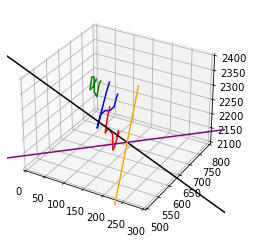

In [24]:
num_trial = working_dfs[0].dropna().to_numpy()
# plot some points in 3d to see what they look like at first
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(num_trial[20:30, 0], num_trial[20:30, 1], num_trial[20:30, 2], 'blue')
ax.plot3D(num_trial[20:30, 3], num_trial[20:30, 4], num_trial[20:30, 5], 'green')
ax.plot3D(num_trial[20:30, 6], num_trial[20:30, 7], num_trial[20:30, 8], 'red')

#get original coord vectors in mask space
t_i = np.linalg.inv(T) * 10000
i_ = np.concatenate([-t_i[0, :].reshape(1, -1), t_i[0, :].reshape(1, -1)], axis=0)
j_ = np.concatenate([-t_i[1, :].reshape(1, -1), t_i[1, :].reshape(1, -1)], axis=0)
k_ = np.concatenate([-t_i[2, :].reshape(1, -1), t_i[2, :].reshape(1, -1)], axis=0)

ax.plot3D(i_[:, 0] + 200, i_[:, 1] + 600, i_[:, 2] + 2200, 'purple')
ax.plot3D(j_[:, 0]  + 200, j_[:, 1] + 600, j_[:, 2] + 2200, 'black')
ax.plot3D(k_[:, 0] + 200, k_[:, 1] + 600, k_[:, 2] + 2200, 'orange')

ax.axes.set_xlim3d(left=0, right=300)
ax.axes.set_ylim3d(bottom=500, top=800)
ax.axes.set_zlim3d(bottom=2100, top=2400)

plt.show()

In [25]:
b1_total = []
b2_total = []
b3_total = []
# do some initial data cleaning, remove ridiculous outliers
for i, trial_df in enumerate(working_dfs):
    if trial_df is None:
        continue
    num_trial = trial_df.dropna().to_numpy()
    b1_total.append(num_trial[:, 0:3])
    b2_total.append(num_trial[:, 3:6])
    b3_total.append(num_trial[:, 6:9])
    index = np.array(trial_df.dropna().index).astype(np.int)
    trial_df.rolling(3).mean()
    working_dfs[i] = trial_df

(array([  0.,   1.,   4.,  13.,  78., 161., 238., 283., 342., 459., 515.,
        544., 547., 550., 537., 527., 434., 418., 397., 279.]),
 array([  0.,  15.,  30.,  45.,  60.,  75.,  90., 105., 120., 135., 150.,
        165., 180., 195., 210., 225., 240., 255., 270., 285., 300.]),
 <BarContainer object of 20 artists>)

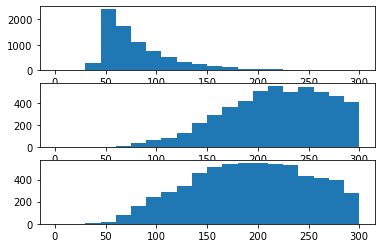

In [26]:
# compute triangle size
b1 = np.concatenate(b1_total, axis=0)
b2 = np.concatenate(b2_total, axis=0)
b3 = np.concatenate(b3_total, axis=0)

len_ear = np.linalg.norm(b1 - b2, axis=1)
len_left = np.linalg.norm(b3 - b2, axis=1)
len_right = np.linalg.norm(b3 - b1, axis=1)

mean_ear = np.mean(len_ear)
std_ear = np.std(len_ear)
mean_left = np.mean(len_left)
std_left = np.std(len_left)
mean_right = np.mean(len_right)
std_right = np.std(len_right)        

fig, ax = plt.subplots(3)
ax[0].hist(len_ear, bins=20, range=(0, 300), label="ear")
ax[1].hist(len_left, bins=20, range=(0, 300), label="left")
ax[2].hist(len_right, bins=20, range=(0, 300), label="right")

237.22432440964704


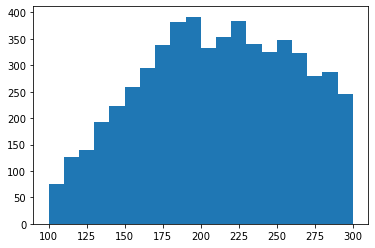

In [28]:
# We are also interested in the vector through the nose
midpoint_ear = (b1 + b2) / 2
nose_vec = b3 - midpoint_ear
len_nose_vec = np.linalg.norm(nose_vec, axis=1)
target_nose = np.median(len_nose_vec)
std_nose = np.std(len_nose_vec)
plt.hist(len_nose_vec, bins=20, range=(100, 300), label="nose vec")
print(target_nose)

# and the drop along the normal from the ear midpoint to the nose
# ear_vec = b1 - b2
# normal_vec = np.cross(ear_vec, nose_vec)
# normal_vec /= np.linalg.norm(normal_vec)
# len_drop = np.einsum('ij,ij->i', nose_vec, normal_vec)
# plt.hist(len_drop, bins=20, range=(0, 300), label="nose vec")
# target_drop = np.median(len_drop)
# print(target_drop)

In [29]:
# function to repair nose vector length
def repair_nose(arr: np.ndarray, nose_target):
    b1 = arr[:, 0:3]
    b2 = arr[:, 3:6]
    b3 = arr[:, 6:9]

    midpoint_ear = (b1 + b2) / 2
    nose_vec = b3 - midpoint_ear
    target_nose_vec = (nose_target / np.linalg.norm(nose_vec, axis=1)).reshape(-1, 1) * nose_vec
    b3f = midpoint_ear - target_nose_vec
    arr[:, 6:9] = b3f
    return arr

sess_name = os.path.basename(os.path.normpath(traj_data))
save_loc = os.path.join(sess_name, 'transformed')
try:
    os.mkdir(save_loc)
except FileExistsError:
    pass
b1_total = []
b2_total = []
b3_total = []

for clip_id, trial_df in enumerate(working_dfs):
    if trial_df is None:
        continue
    trial_df = trial_df.copy()
    num_trial = trial_df.dropna().to_numpy()
    index = np.array(trial_df.dropna().index).astype(np.int)
    num_trial = repair_nose(num_trial, target_nose)
    #transform into mask coordinate system
    b1_total.append(num_trial[:, 0:3])
    b2_total.append(num_trial[:, 3:6])
    b3_total.append(num_trial[:, 6:9])

    trial_df.loc[index, :] = num_trial

    #another round of very local linear interpolation
    try:
        trial_df.interpolate(method='linear', axis=0, limit=5, limit_direction='both', inplace=True, limit_area='inside')
    except Exception:
        continue
    # do a round of higher order interpolation to try to model bodypart 3 dropped areas
    # trial_df.interpolate(method='quadratic', axis=0, limit=5, limit_direction='both', inplace=True, limit_area='inside')
    
    # drop any remaining nans
    trial_df.dropna(inplace=True)         
    
    if trial_df.shape[0] > 5:
        print('writing transformed coordinates for clip ', clip_id)
        fname = 'clip_' + str(clip_id) + '_transformed_3D.csv'
        trial_df.to_csv(os.path.join(save_loc, fname))


writing transformed coordinates for clip  0
writing transformed coordinates for clip  2
writing transformed coordinates for clip  3
writing transformed coordinates for clip  5
writing transformed coordinates for clip  6
writing transformed coordinates for clip  7
writing transformed coordinates for clip  8
writing transformed coordinates for clip  9
writing transformed coordinates for clip  10
writing transformed coordinates for clip  11
writing transformed coordinates for clip  12
writing transformed coordinates for clip  13
writing transformed coordinates for clip  14
writing transformed coordinates for clip  15
writing transformed coordinates for clip  16
writing transformed coordinates for clip  17
writing transformed coordinates for clip  18
writing transformed coordinates for clip  19
writing transformed coordinates for clip  20
writing transformed coordinates for clip  21
writing transformed coordinates for clip  22
writing transformed coordinates for clip  24
writing transforme

(array([0.000e+00, 0.000e+00, 3.000e+00, 1.000e+00, 2.000e+00, 1.000e+00,
        4.000e+00, 7.000e+00, 4.000e+00, 5.000e+00, 1.000e+01, 1.300e+01,
        3.200e+01, 8.500e+01, 2.520e+02, 8.850e+02, 1.956e+03, 2.070e+03,
        1.212e+03, 6.340e+02]),
 array([  0.,  15.,  30.,  45.,  60.,  75.,  90., 105., 120., 135., 150.,
        165., 180., 195., 210., 225., 240., 255., 270., 285., 300.]),
 <BarContainer object of 20 artists>)

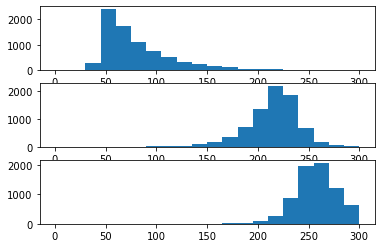

In [30]:
#Visualize the distribution of sizes after processing
# compute triangle size
b1 = np.concatenate(b1_total, axis=0)
b2 = np.concatenate(b2_total, axis=0)
b3 = np.concatenate(b3_total, axis=0)

len_ear = np.linalg.norm(b1 - b2, axis=1)
len_left = np.linalg.norm(b3 - b2, axis=1)
len_right = np.linalg.norm(b3 - b1, axis=1)

mean_ear = np.mean(len_ear)
std_ear = np.std(len_ear)
mean_left = np.mean(len_left)
std_left = np.std(len_left)
mean_right = np.mean(len_right)
std_right = np.std(len_right)

fig, ax = plt.subplots(3)
ax[0].hist(len_ear, bins=20, range=(0, 300), label="ear")
ax[1].hist(len_left, bins=20, range=(0, 300), label="left")
ax[2].hist(len_right, bins=20, range=(0, 300), label="right")


Now we will get angles from transformed coordinates

In [15]:
# # get vector lengths 
# sess_name = os.path.basename(os.path.normpath(traj_data))
# transformed_files = os.path.join(r"F:\MysoreData\nbk\mouseVideoAnalysis\Box1\analysis\transformed", sess_name)
# b1_total = []
# b2_total = []
# b3_total = []
# for f in os.listdir(transformed_files):
#     if '_3D.csv' in f:
#         clip_id = re.split(r'_|-', f)[1]
#         trial_df = pd.read_csv(os.path.join(transformed_files, f))
#         num_trial = trial_df.to_numpy()
        
#         index = num_trial[:, 0].astype(np.int)
        
#         b1_total.append(num_trial[:, 1:4])
#         b2_total.append(num_trial[:, 4:7])
#         b3_total.append(num_trial[:, 7:10])

# b1 = np.concatenate(b1_total, axis=0)
# b2 = np.concatenate(b2_total, axis=0)
# b3 = np.concatenate(b3_total, axis=0)

# len_ear = np.linalg.norm(b1 - b2, axis=1)
# len_left = np.linalg.norm(b3 - b2, axis=1)
# len_right = np.linalg.norm(b3 - b1, axis=1)

# fig, ax = plt.subplots(3)
# ax[0].hist(len_ear, bins=10, range=(0, 10), label="ear")
# ax[1].hist(len_left, bins=20, range=(0, 20), label="left")
# ax[2].hist(len_right, bins=20, range=(0, 20), label="right")



In [31]:
# return the normal vector (orthogonal to the head) and the ear vector (between the two ears)
def get_normals(b1_coords:np.ndarray, b2_coords:np.ndarray, b3_coords:np.ndarray):
    """
    b1_coord: 3D coordinates for left ear base
    b2_coord: 3D coordinates for right ear base 
    b3_coords: 3D coordinates for nose
    """
    ear_vec = b1 - b2
    midpoint_ear = (b1 + b2) / 2
    nose_vec = b3 - midpoint_ear
    normal_vec = np.cross(ear_vec, nose_vec)
    normal_vec = normal_vec / np.linalg.norm(normal_vec, axis=1).reshape(-1, 1)
    ear_vec = ear_vec / np.linalg.norm(ear_vec, axis=1).reshape(-1, 1)
    nose_vec = nose_vec / np.linalg.norm(nose_vec, axis=1).reshape(-1, 1) * -1
    return normal_vec, ear_vec, nose_vec

<ipython-input-33-c44fff12cf0f>:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


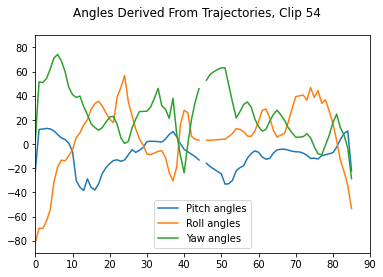

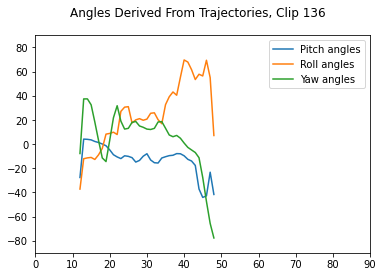

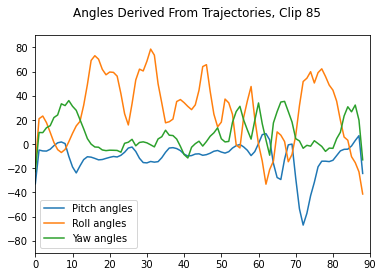

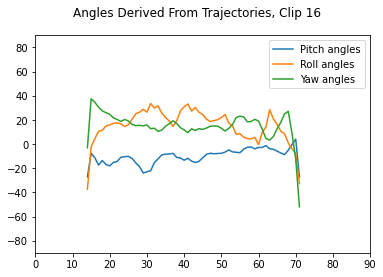

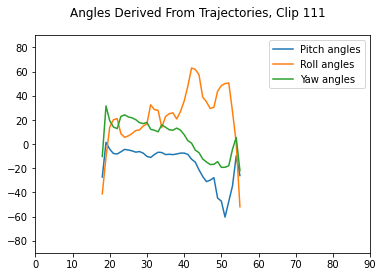

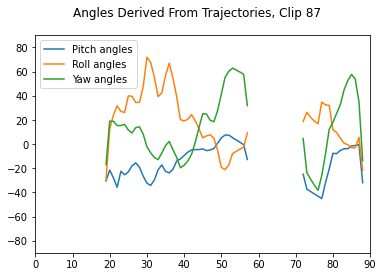

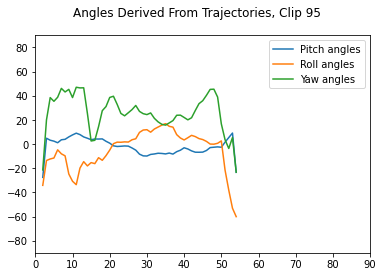

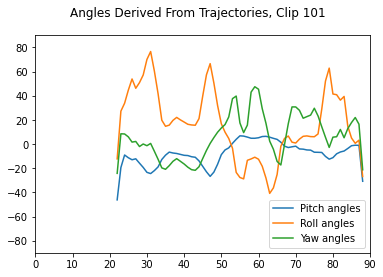

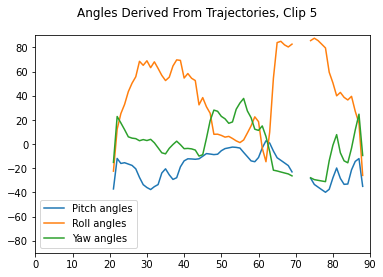

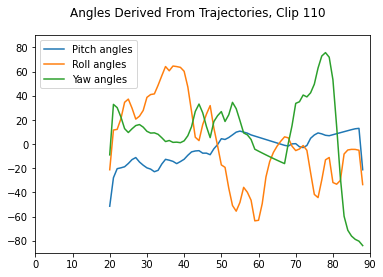

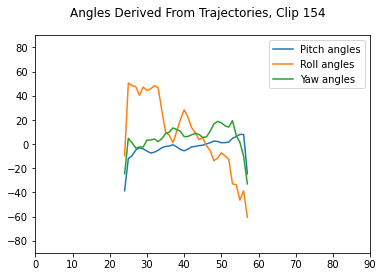

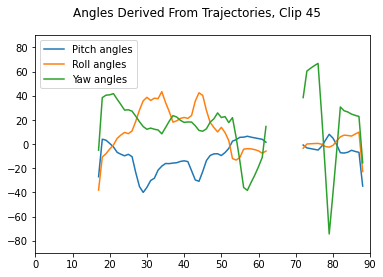

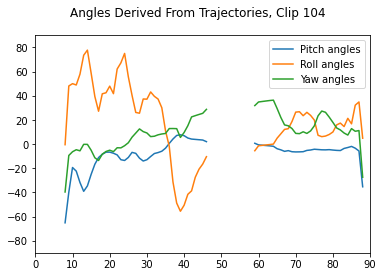

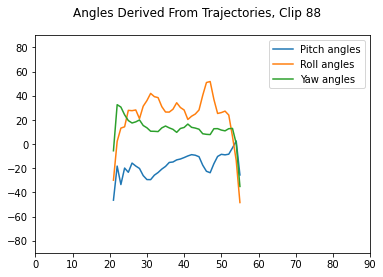

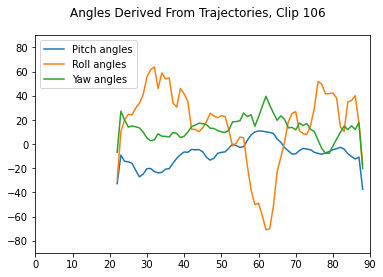

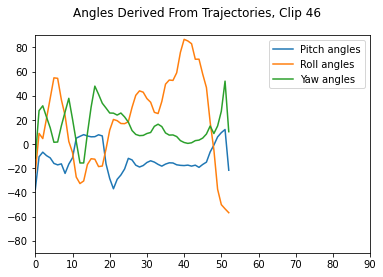

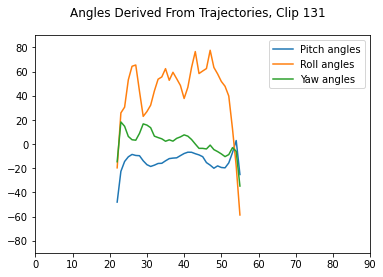

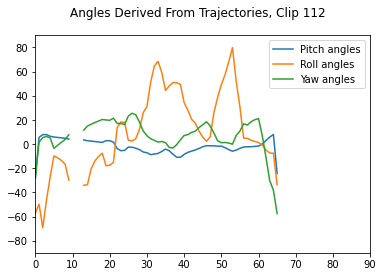

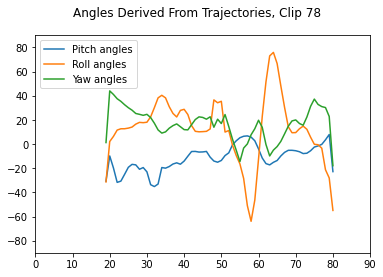

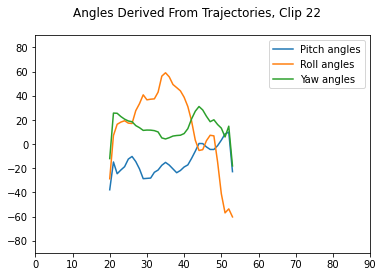

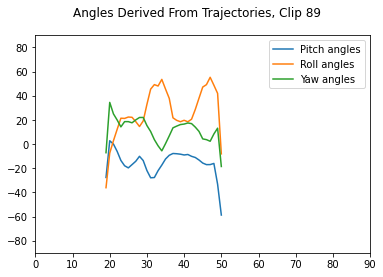

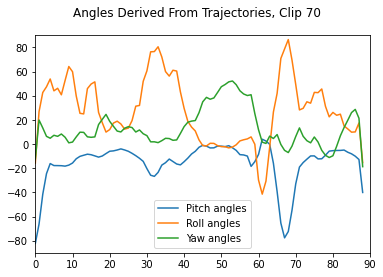

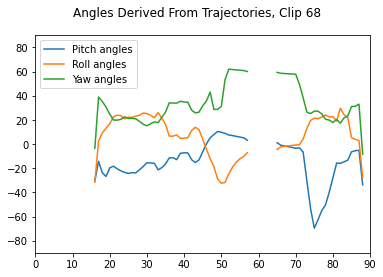

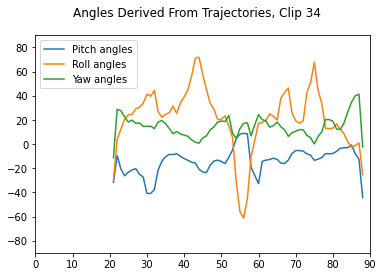

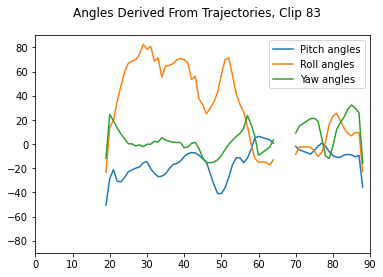

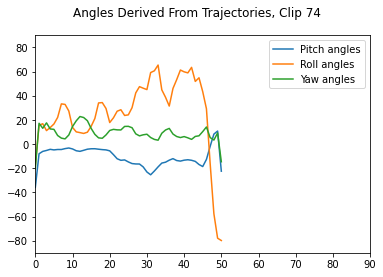

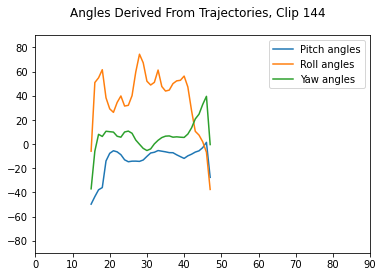

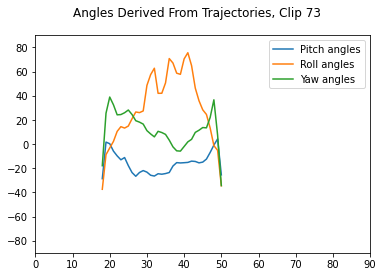

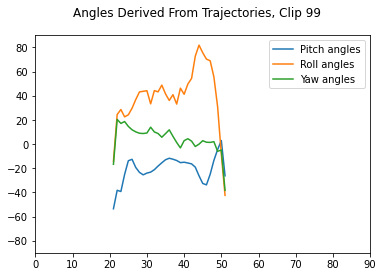

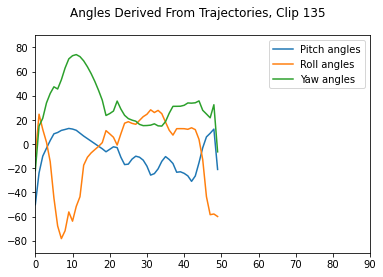

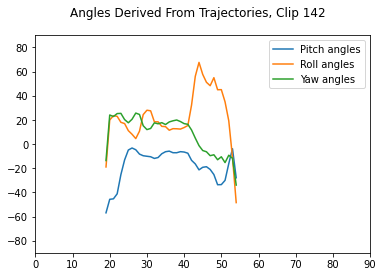

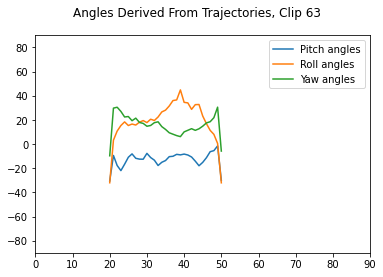

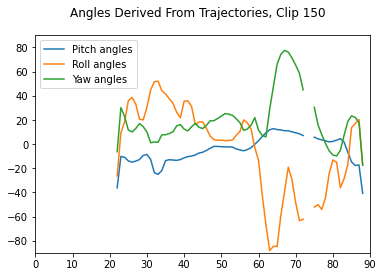

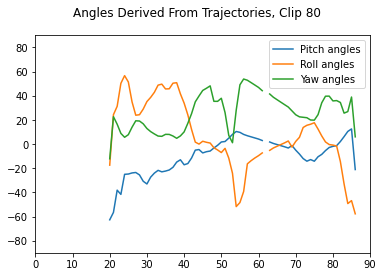

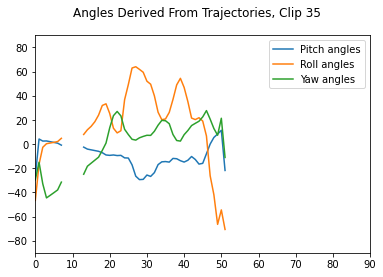

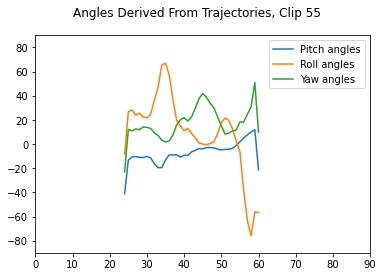

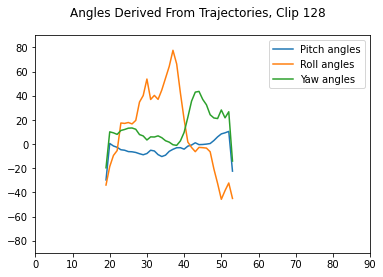

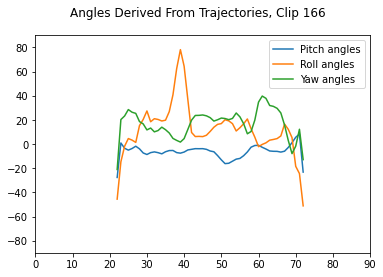

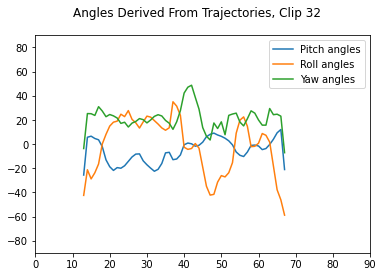

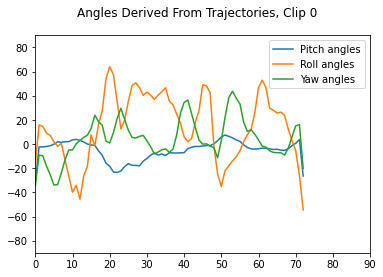

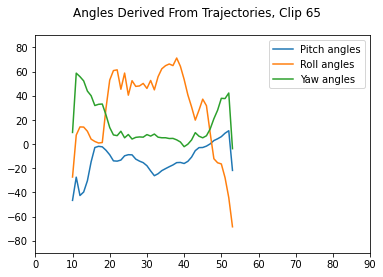

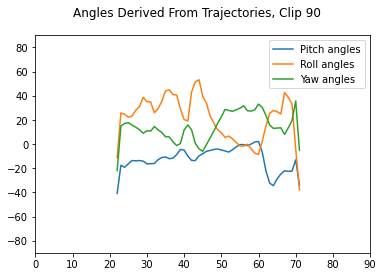

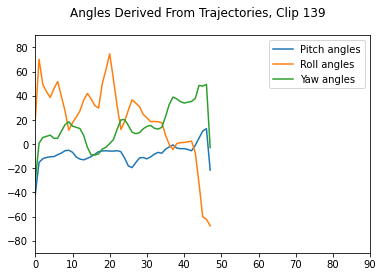

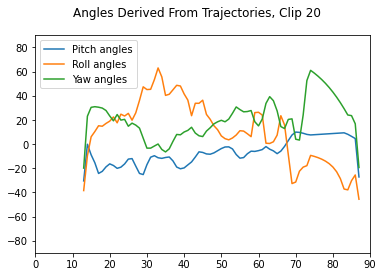

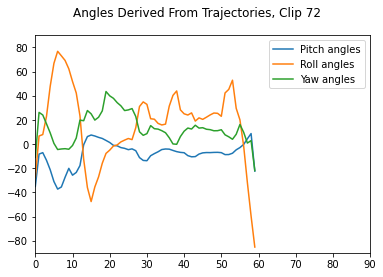

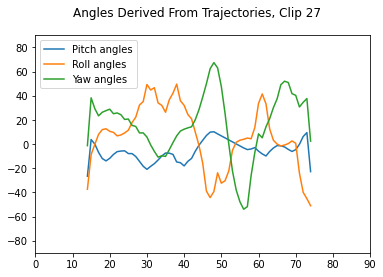

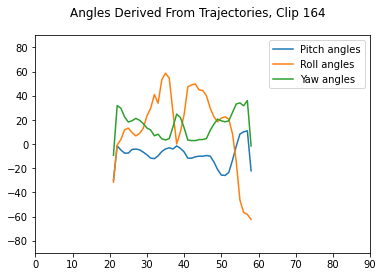

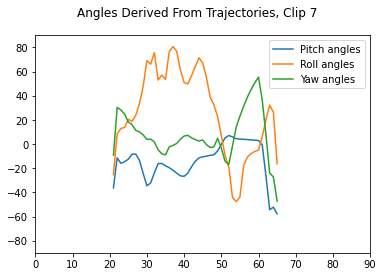

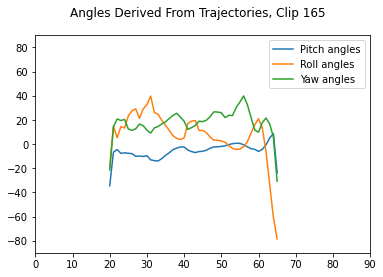

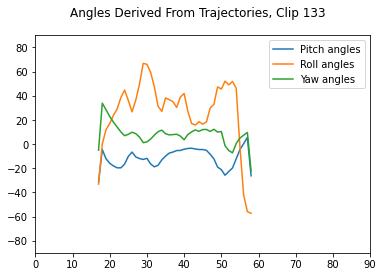

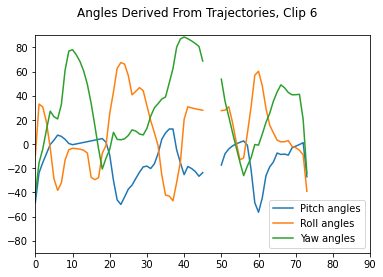

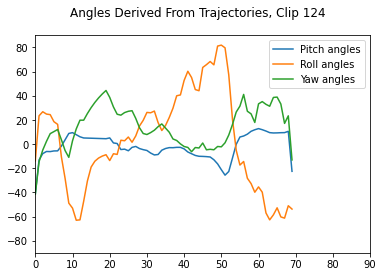

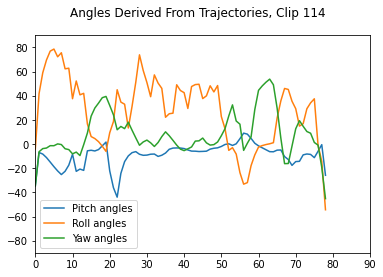

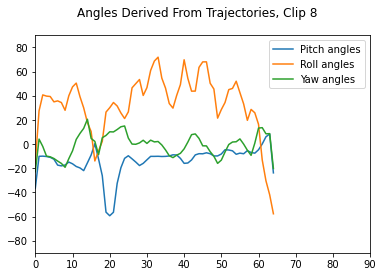

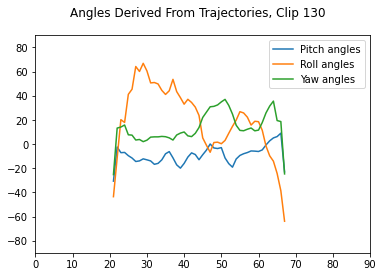

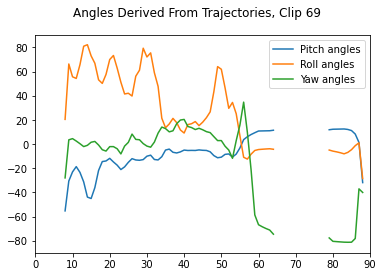

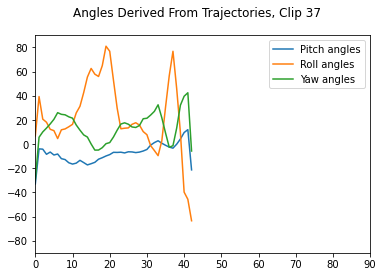

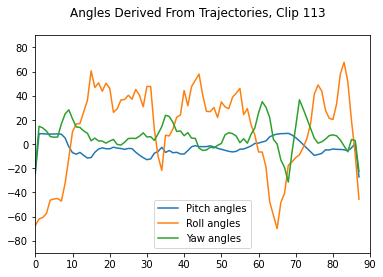

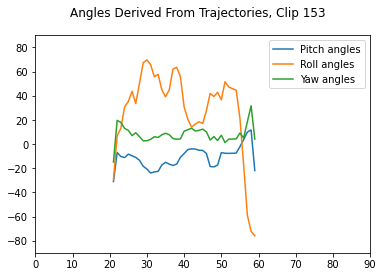

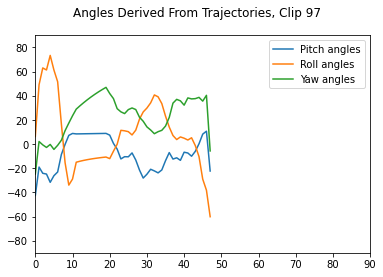

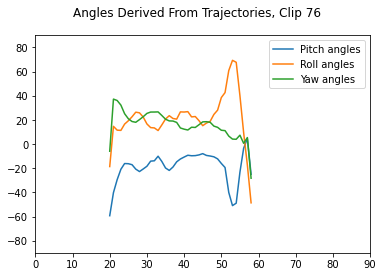

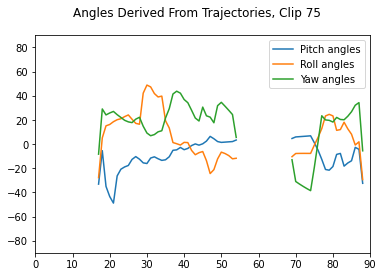

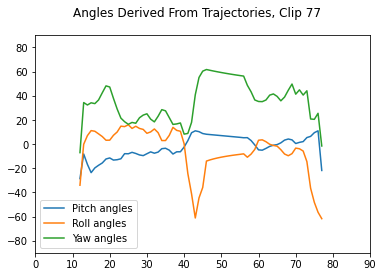

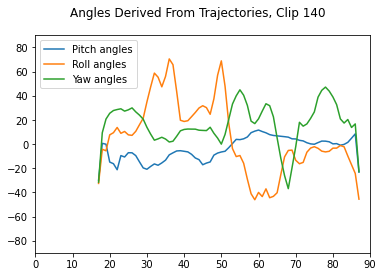

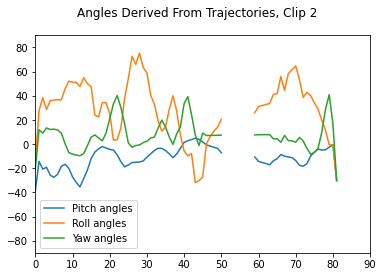

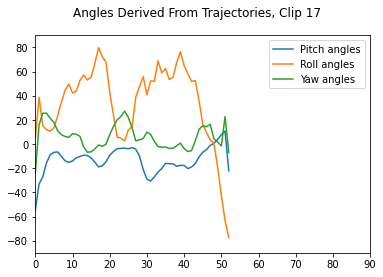

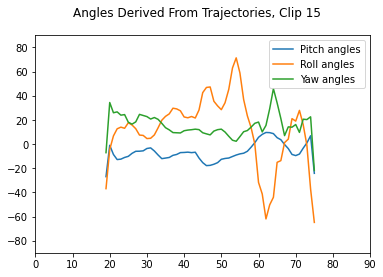

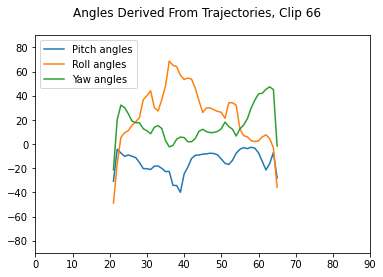

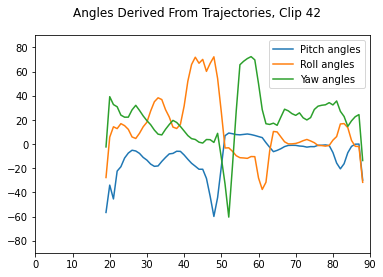

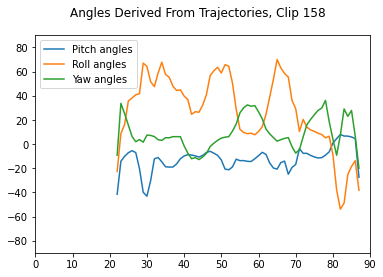

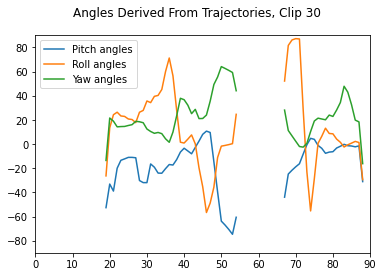

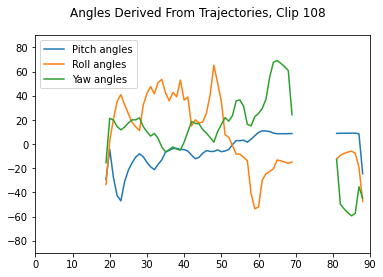

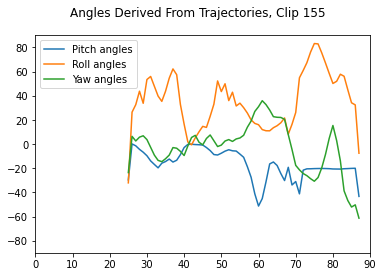

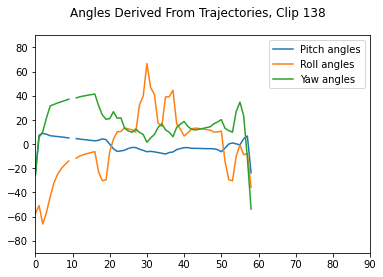

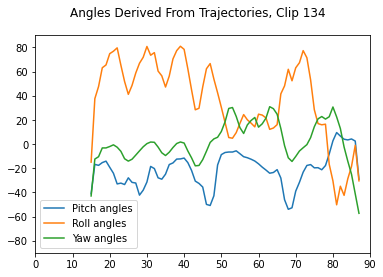

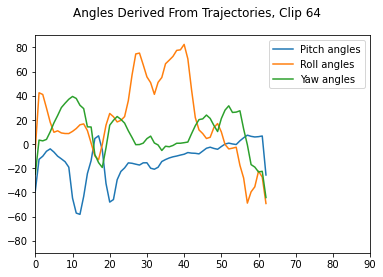

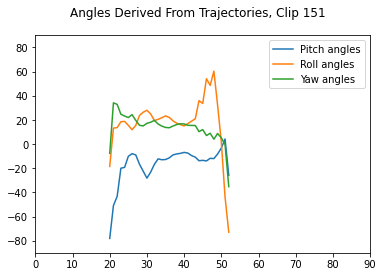

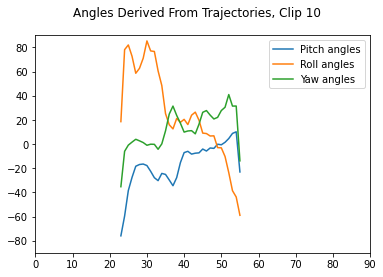

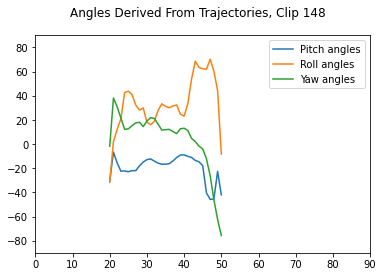

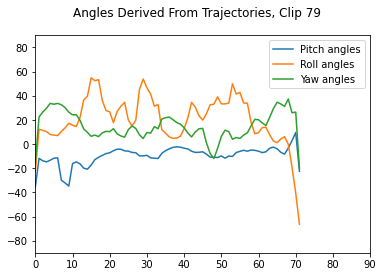

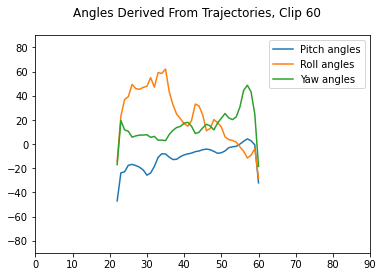

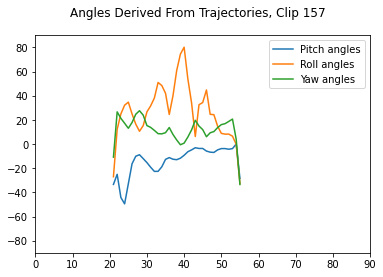

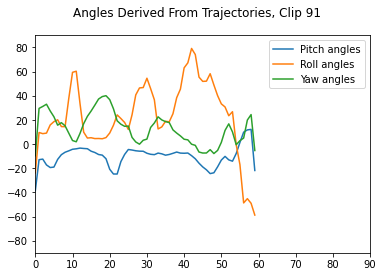

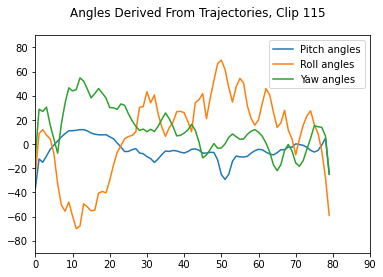

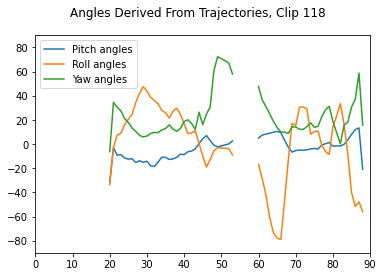

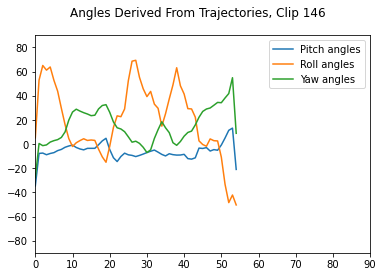

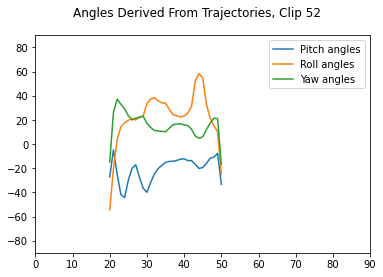

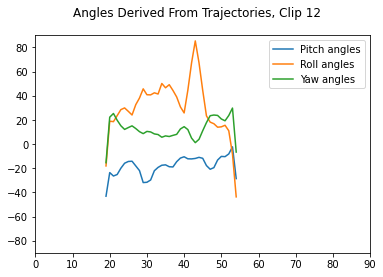

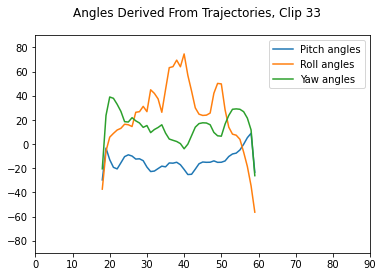

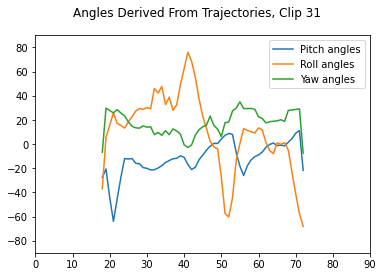

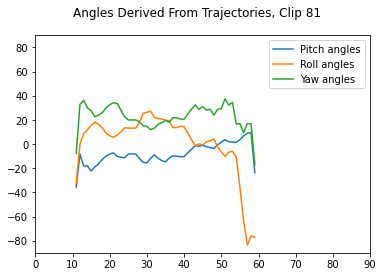

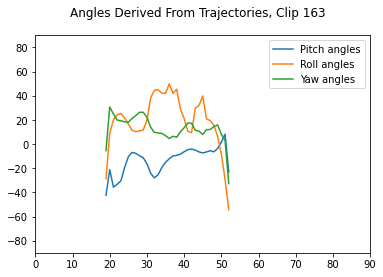

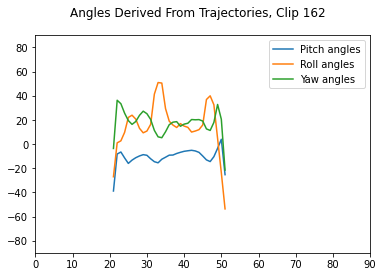

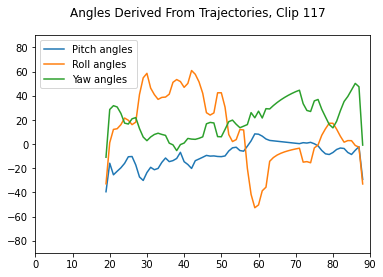

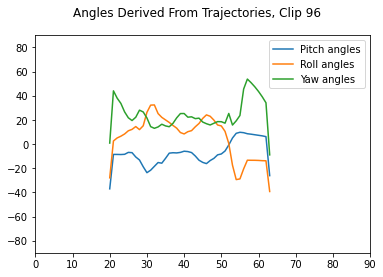

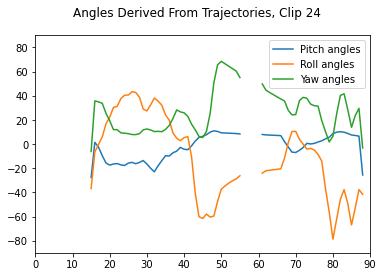

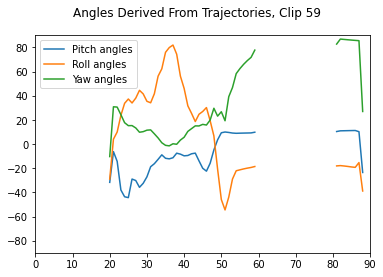

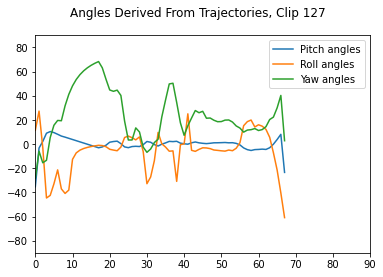

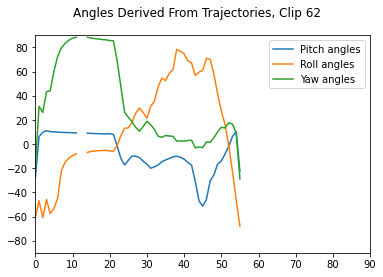

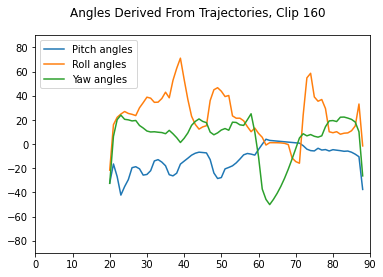

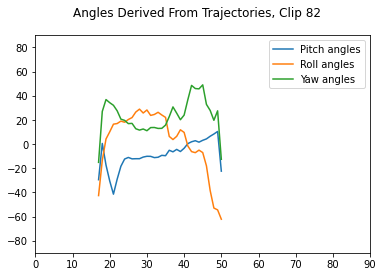

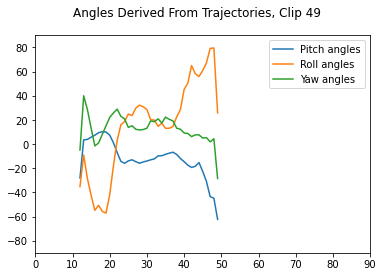

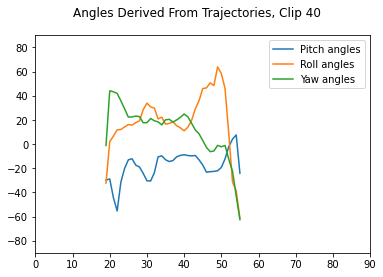

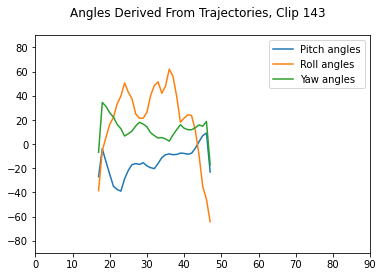

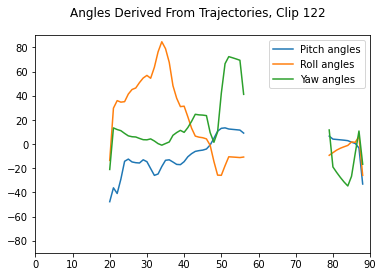

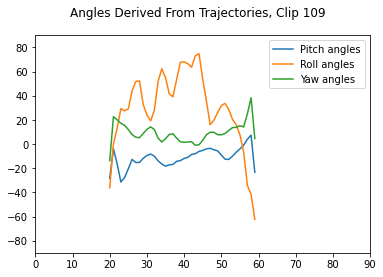

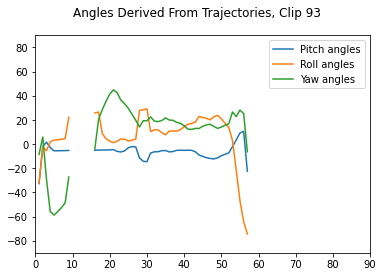

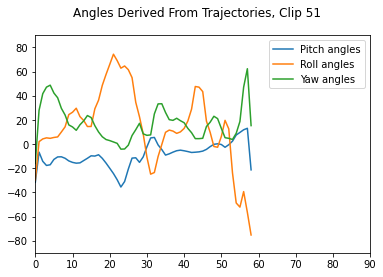

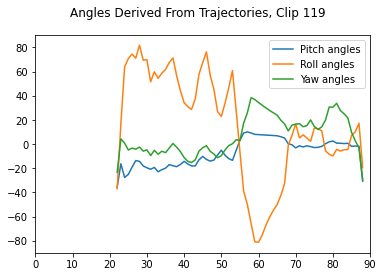

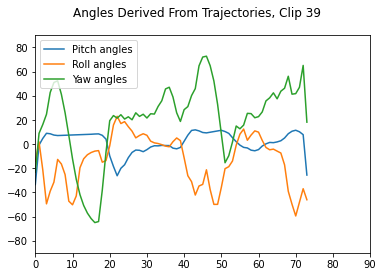

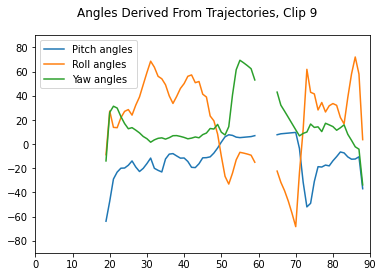

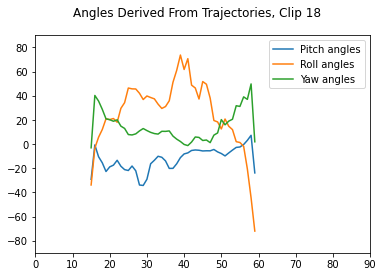

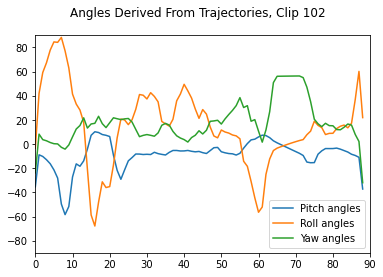

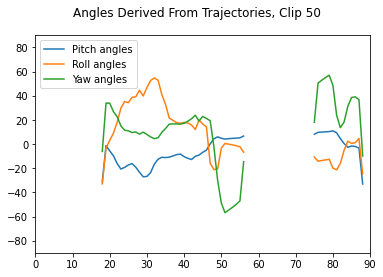

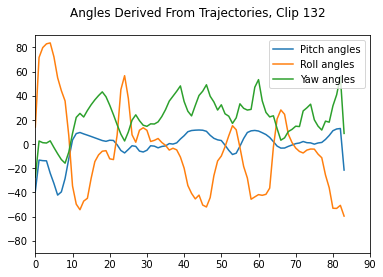

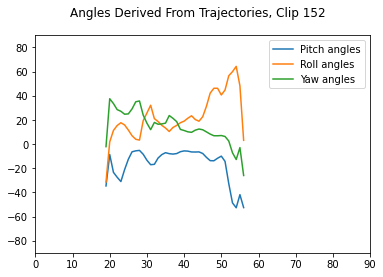

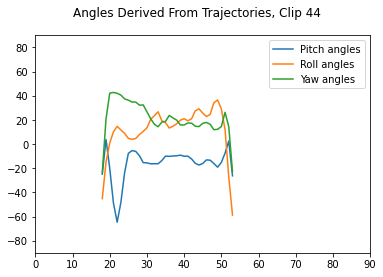

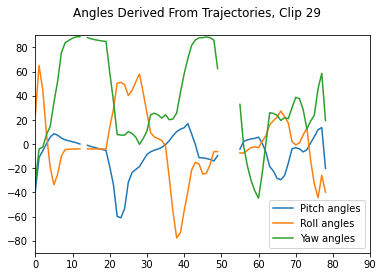

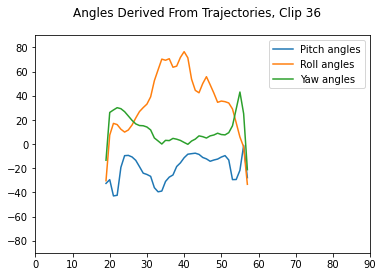

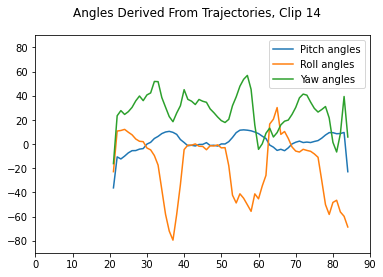

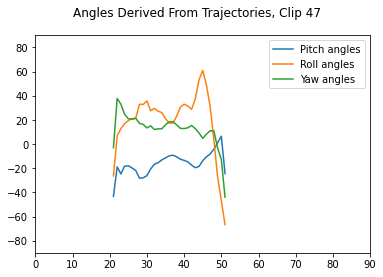

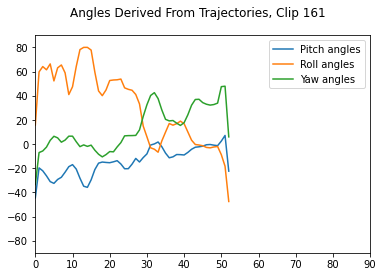

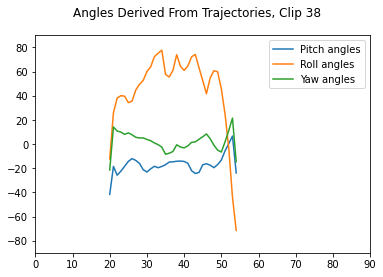

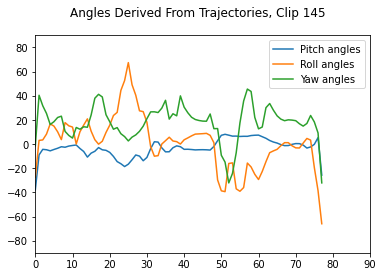

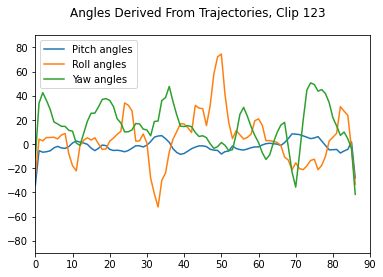

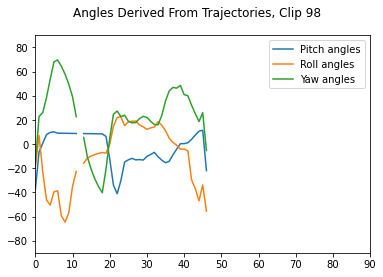

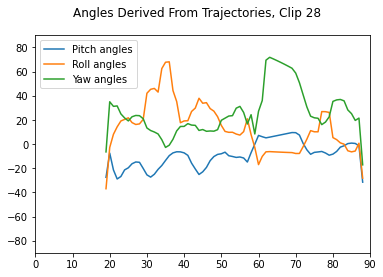

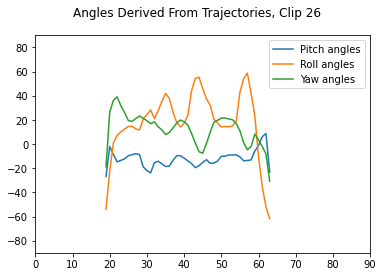

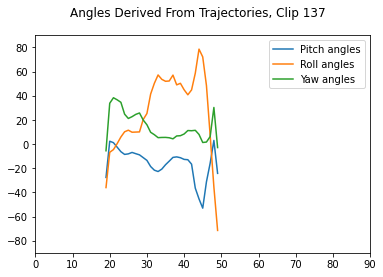

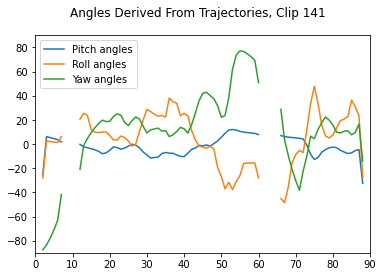

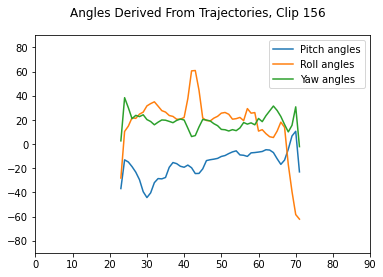

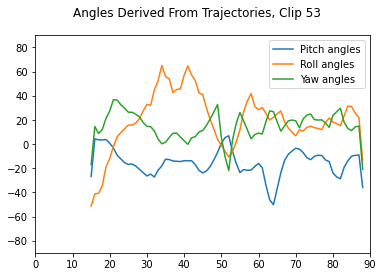

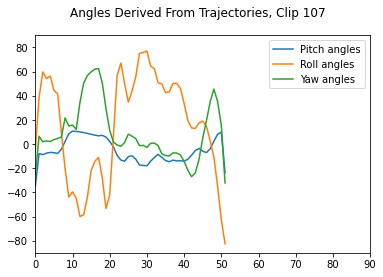

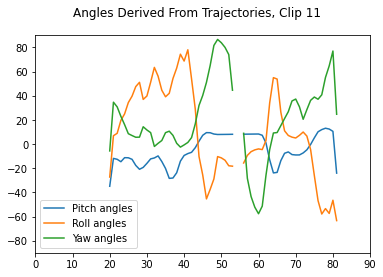

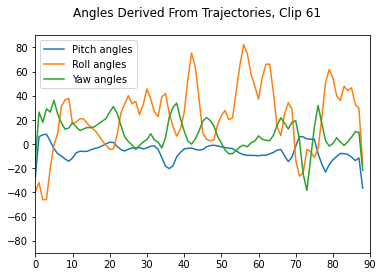

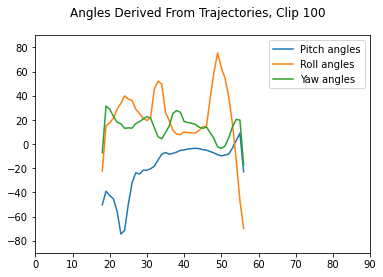

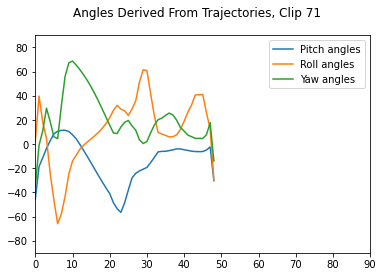

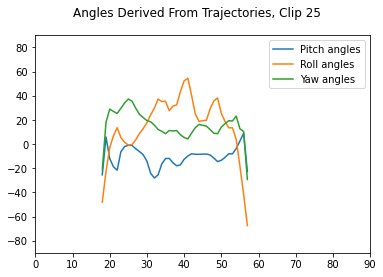

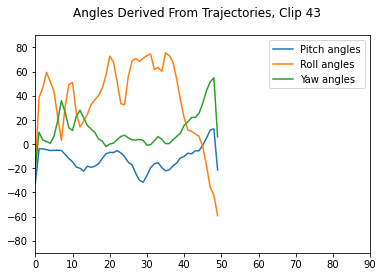

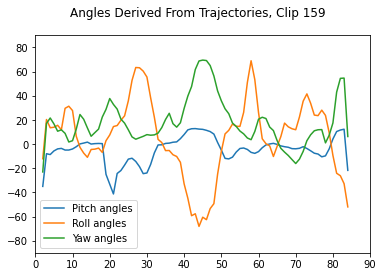

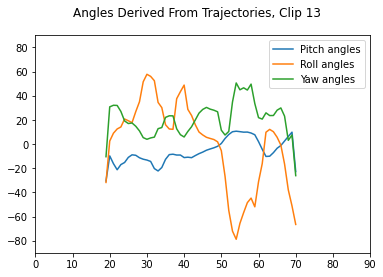

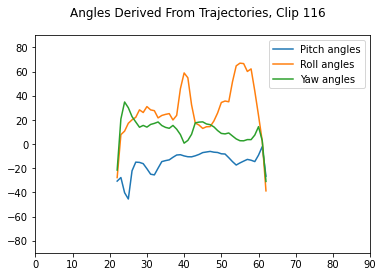

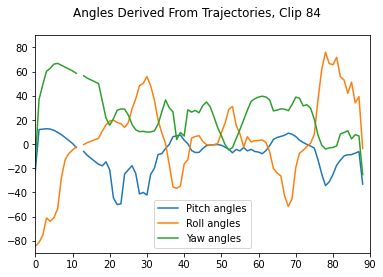

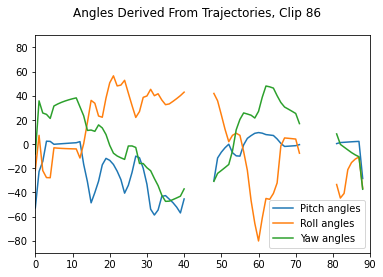

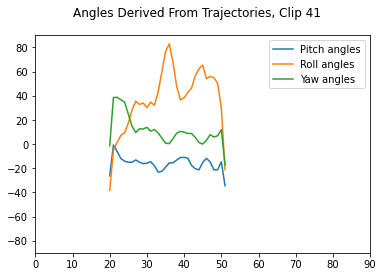

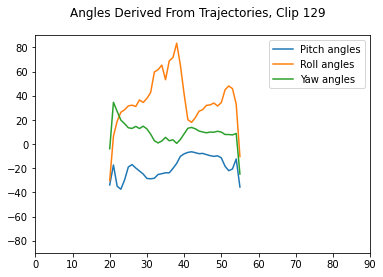

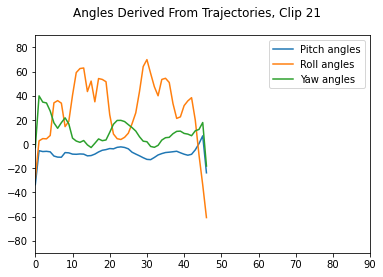

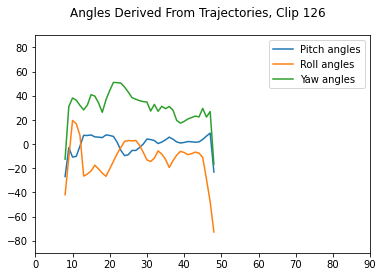

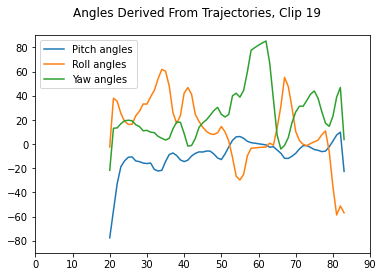

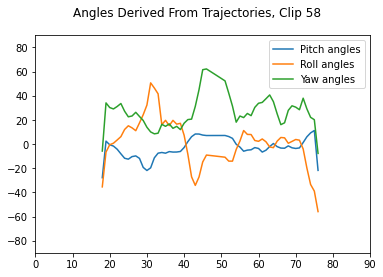

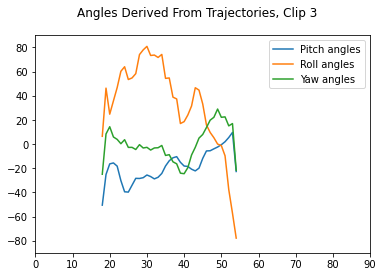

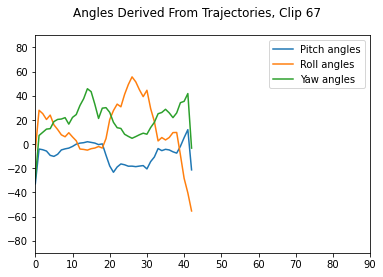

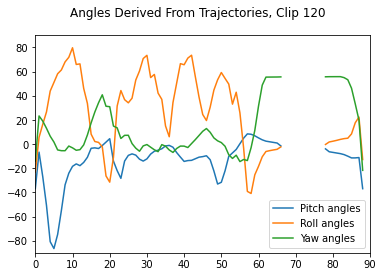

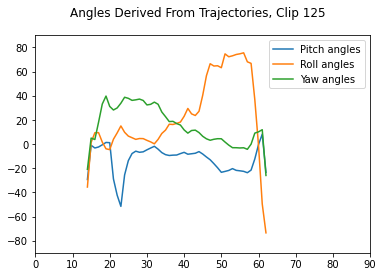

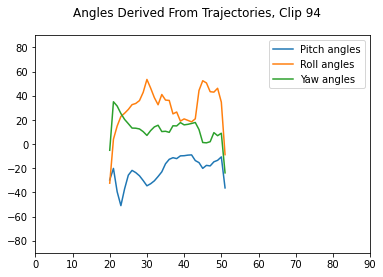

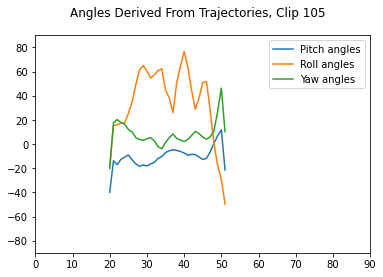

In [33]:
def compute_roll(vec, smooth=True):
    # project normal vector onto i, k plain
    proj = vec[:, (0, 2)]
    #normalize
    proj /= np.linalg.norm(proj, axis=1).reshape(-1, 1)
    # angle on i, k plain from i
    angle = np.arccos(np.dot(proj, np.array([0, 1])))
    if smooth:
        angle = np.convolve(angle, np.ones(3), 'same') / 3
    return np.degrees(angle - np.pi / 2)

def compute_pitch(vec, smooth=True):
    # project nose vector onto j, k plain
    proj = vec[:, (1, 2)]
    proj /= np.linalg.norm(proj, axis=1).reshape(-1, 1)
    #angle on j,k plain from k
    angle = np.arccos(np.dot(proj, np.array([1, 0])))
    if smooth:
        angle = np.convolve(angle, np.ones(3), 'same') / 3
    return np.degrees(angle - np.pi / 2)

def compute_yaw(vec, smooth=True):
    # project ear vector onto i, j plain
    proj = vec[:, (0, 1)]
    proj /= np.linalg.norm(proj, axis=1).reshape(-1, 1)
    # angle on i, j plain from j
    angle = np.arccos(np.dot(proj, np.array([0, 1])))
    if smooth:
        angle = np.convolve(angle, np.ones(3), 'same') / 3
    return np.degrees(angle - np.pi / 2)


sess_name = os.path.basename(os.path.normpath(traj_data))
transformed_files = os.path.join(sess_name, 'transformed')
save_loc = os.path.join(sess_name, 'angles')
try:
    os.mkdir(save_loc)
except FileExistsError:
    pass
try:
    os.mkdir(os.path.join(save_loc, 'plots'))
except FileExistsError:
    pass
for f in os.listdir(transformed_files):
    if '_3D.csv' in f:
        clip_id = re.split(r'_|-', f)[1]
        trial_df = pd.read_csv(os.path.join(transformed_files, f))
        num_trial = trial_df.to_numpy()
        
        index = num_trial[:, 0].astype(np.int)
        
        b1 = num_trial[:, 1:4]
        b2 = num_trial[:, 4:7]
        b3 = num_trial[:, 7:10]
        
        norm, ear, nose = get_normals(b1, b2, b3)

        roll_angles = compute_roll(norm)
        pitch_angles = compute_pitch(nose)
        yaw_angles = compute_yaw(ear)

        roll_map = np.empty([90]) * np.nan
        pitch_map = np.empty([90]) * np.nan
        yaw_map = np.empty([90]) * np.nan
        
        roll_map[index] = roll_angles
        pitch_map[index] = pitch_angles
        yaw_map[index] = yaw_angles
        
        df = pd.DataFrame(np.stack([pitch_angles, yaw_angles, roll_angles], axis=1), columns=["Pitch", "Yaw", "Roll"])
        df.to_csv(os.path.join(save_loc, "unfiltered_angles_clip_" + str(clip_id) + ".csv"))
        
        fig, ax = plt.subplots()
        ax.plot(np.arange(90), pitch_map, label="Pitch angles")
        ax.plot(np.arange(90), roll_map, label="Roll angles")
        ax.plot(np.arange(90), yaw_map, label="Yaw angles")
        ax.set_xlim(0, 90)
        ax.set_ylim(-90, 90)
        fig.suptitle("Angles Derived From Trajectories, Clip " + str(clip_id))
        ax.legend()
        fig.savefig(os.path.join(save_loc, "plots", "unfiltered_plot_clip_" + str(clip_id) + ".png"), format='png')

- after training network again (double the amount of data )
- discard points outside 10% range on vector length 
- angle plot without interpolation, and with 